# Where's Waldo?

Importing the data

In [2]:
!pip install kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 6.4 MB/s eta 0:00:00
DEPRECATION: pytorch-lightning 1.6.0 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("residentmario/wheres-waldo")

print("Path to dataset files:", path)

/Users/laurenbeede/miniconda3/envs/lfads-torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 248M/248M [00:22<00:00, 11.8MB/s] 

Extracting files...


Path to dataset files: /Users/laurenbeede/.cache/kagglehub/datasets/residentmario/wheres-waldo/versions/2


## Testing the images of Waldo

In [4]:
import matplotlib.pyplot as plt
import os
datapath = path+'/wheres-waldo/Hey-Waldo'

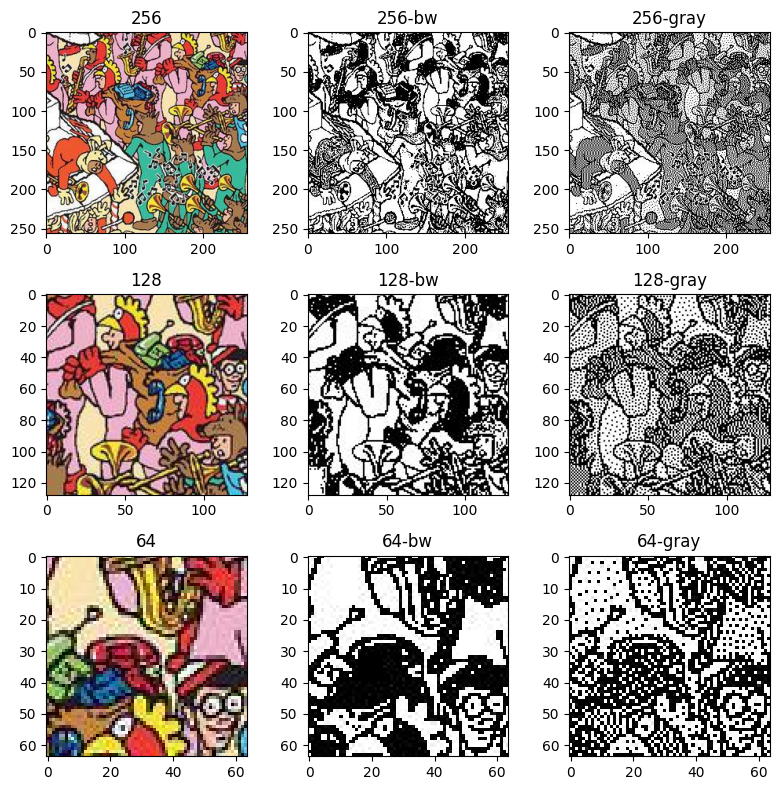

In [10]:
fig, axarr = plt.subplots(3, 3, figsize=(8, 8))

im = plt.imread(datapath+"/256/waldo/10_3_1.jpg")
axarr[0][0].imshow(im)
axarr[0][0].set_title("256")

im = plt.imread(datapath+"/256-bw/waldo/10_3_1.jpg")
axarr[0][1].imshow(im)
axarr[0][1].set_title("256-bw")

im = plt.imread(datapath+"/256-gray/waldo/10_3_1.jpg")
axarr[0][2].imshow(im)
axarr[0][2].set_title("256-gray")

im = plt.imread(datapath+"/128/waldo/10_7_2.jpg")
axarr[1][0].imshow(im)
axarr[1][0].set_title("128")

im = plt.imread(datapath+"/128-bw/waldo/10_7_2.jpg")
axarr[1][1].imshow(im)
axarr[1][1].set_title("128-bw")

im = plt.imread(datapath+"/128-gray/waldo/10_7_2.jpg")
axarr[1][2].imshow(im)
axarr[1][2].set_title("128-gray")

im = plt.imread(datapath+"/64/waldo/10_15_4.jpg")
axarr[2][0].imshow(im)
axarr[2][0].set_title("64")

im = plt.imread(datapath+"/64-bw/waldo/10_15_4.jpg")
axarr[2][1].imshow(im)
axarr[2][1].set_title("64-bw")

im = plt.imread(datapath+"/64-gray/waldo/10_15_4.jpg")
axarr[2][2].imshow(im)
axarr[2][2].set_title("64-gray")

plt.tight_layout()

Problems include:  
- Waldo as differs in size
- Many more not-waldo images than waldo images
- Waldo can be obstructed

## Object detecting

Installing dependencies

In [11]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn ## Pre-trained model from PyTorch
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [24]:
numnotwaldo = len(os.listdir(datapath+'/128/notwaldo/'))
numwaldo = len(os.listdir(datapath+'/128/waldo/'))

Have to label/annotate the Waldo images.

Config.py ::

In [ ]:
# import the necessary packages
import torch
import os
# define the base path to the input dataset and then use it to derive
# the path to the input images and annotation CSV files
BASE_PATH = "dataset"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "annotations"])
# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the output model, label encoder, plots output
# directory, and testing image paths
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.pth"])
LE_PATH = os.path.sep.join([BASE_OUTPUT, "le.pickle"])
PLOTS_PATH = os.path.sep.join([BASE_OUTPUT, "plots"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [12]:
# determine the current device and based on that set the pin memory
# flag
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# PIN_MEMORY = True if DEVICE == "cuda" else False
# specify ImageNet mean and standard deviation
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 32
# specify the loss weights
LABELS = 1.0
BBOX = 1.0

In [19]:
# import the necessary packages
from torch.utils.data import Dataset
class CustomTensorDataset(Dataset):
	# initialize the constructor
  def __init__(self, tensors, transforms=None):
    self.tensors = tensors
    self.transforms = transforms
  def __getitem__(self, index):
    # grab the image, label, and its bounding box coordinates
    image = self.tensors[0][index]
    label = self.tensors[1][index]
    bbox = self.tensors[2][index]
    # transpose the image such that its channel dimension becomes
    # the leading one
    image = image.permute(2, 0, 1)
    # check to see if we have any image transformations to apply
    # and if so, apply them
    if self.transforms:
      image = self.transforms(image)
    # return a tuple of the images, labels, and bounding
    # box coordinates
    return (image, label, bbox)
  def __len__(self):
    # return the size of the dataset
    return self.tensors[0].size(0)

In [27]:
# import the necessary packages
from torch.nn import Dropout
from torch.nn import Identity
from torch.nn import Linear
from torch.nn import Module
from torch.nn import ReLU
from torch.nn import Sequential
from torch.nn import Sigmoid
class ObjectDetector(Module):
  def __init__(self, baseModel, numClasses):
    super(ObjectDetector, self).__init__()
    # initialize the base model and the number of classes
    self.baseModel = baseModel
    self.numClasses = numClasses
    # build the regressor head for outputting the bounding box
    # coordinates
    self.regressor = Sequential(
      Linear(baseModel.fc.in_features, 128),
      ReLU(),
      Linear(128, 64),
      ReLU(),
      Linear(64, 32),
      ReLU(),
      Linear(32, 4),
      Sigmoid()
    )
    # build the classifier head to predict the class labels
    self.classifier = Sequential(
      Linear(baseModel.fc.in_features, 512),
      ReLU(),
      Dropout(),
      Linear(512, 512),
      ReLU(),
      Dropout(),
      Linear(512, self.numClasses)
    )
    # set the classifier of our base model to produce outputs
    # from the last convolution block
    self.baseModel.fc = Identity()

  def forward(self, x):
    # pass the inputs through the base model and then obtain
    # predictions from two different branches of the network
    features = self.baseModel(x)
    bboxes = self.regressor(features)
    classLogits = self.classifier(features)
    # return the outputs as a tuple
    return (bboxes, classLogits)

In [28]:
# import the necessary packages

from pyimagesearch import config
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from torch.nn import MSELoss
from torch.optim import Adam
from torchvision.models import resnet50
from sklearn.model_selection import train_test_split
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import time
import cv2
import os
# initialize the list of data (images), class labels, target bounding
# box coordinates, and image paths
print("[INFO] loading dataset...")
data = []
labels = []
bboxes = []
imagePaths = []

ModuleNotFoundError: No module named 'pyimagesearch'